<a href="https://colab.research.google.com/github/YasminDayrell/Trainee-CIS/blob/main/traineePeriodo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Upload


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving star_classification.csv to star_classification (2).csv


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


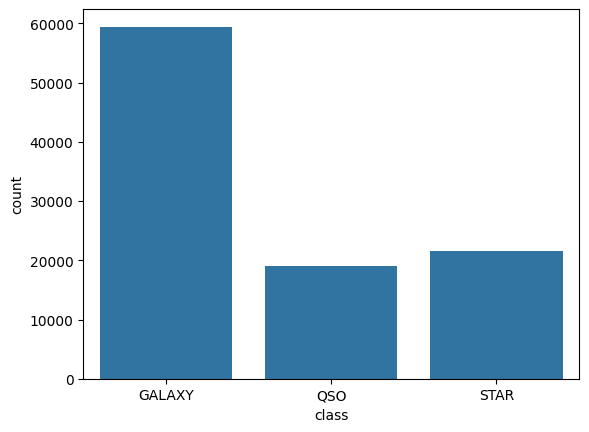

In [ ]:
import pandas as pd
import seaborn as sns

raw_df = pd.read_csv('star_classification.csv')

sns.countplot(x = raw_df["class"])
raw_df.head()

# data treatment

colunas com valores faltantes: 0
samplpes: 100000
obj_ID : 78053
run_ID : 430
rerun_ID : 1
cam_col : 6
field_ID : 856
spec_obj_ID : 100000
fiber_ID : 1000
plate : 6284
Excluindo as colunas que não se referem a dados físicos e as imagens em si, apenas a data, material utilizado etc.


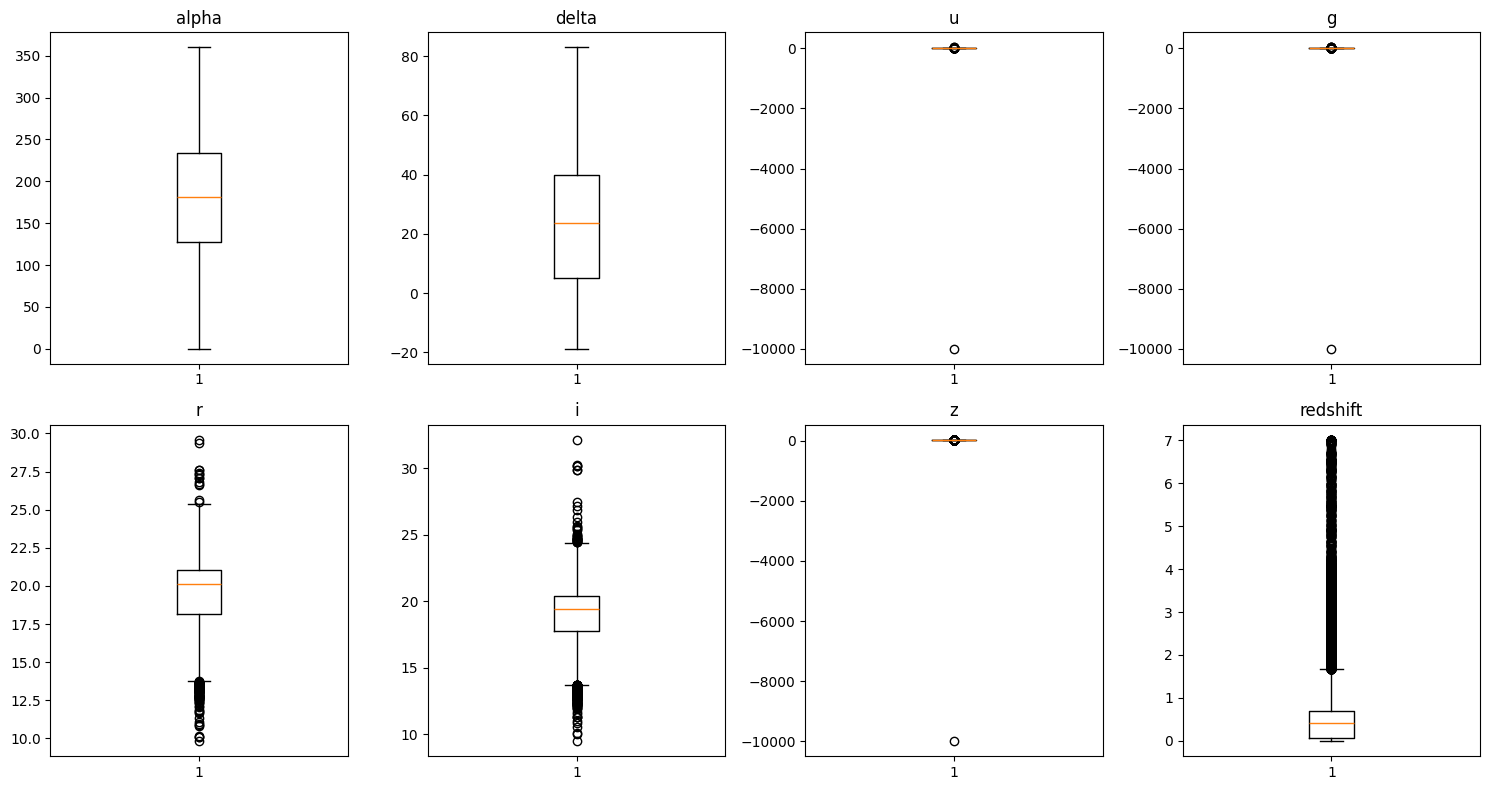


outliers removidos: 9368



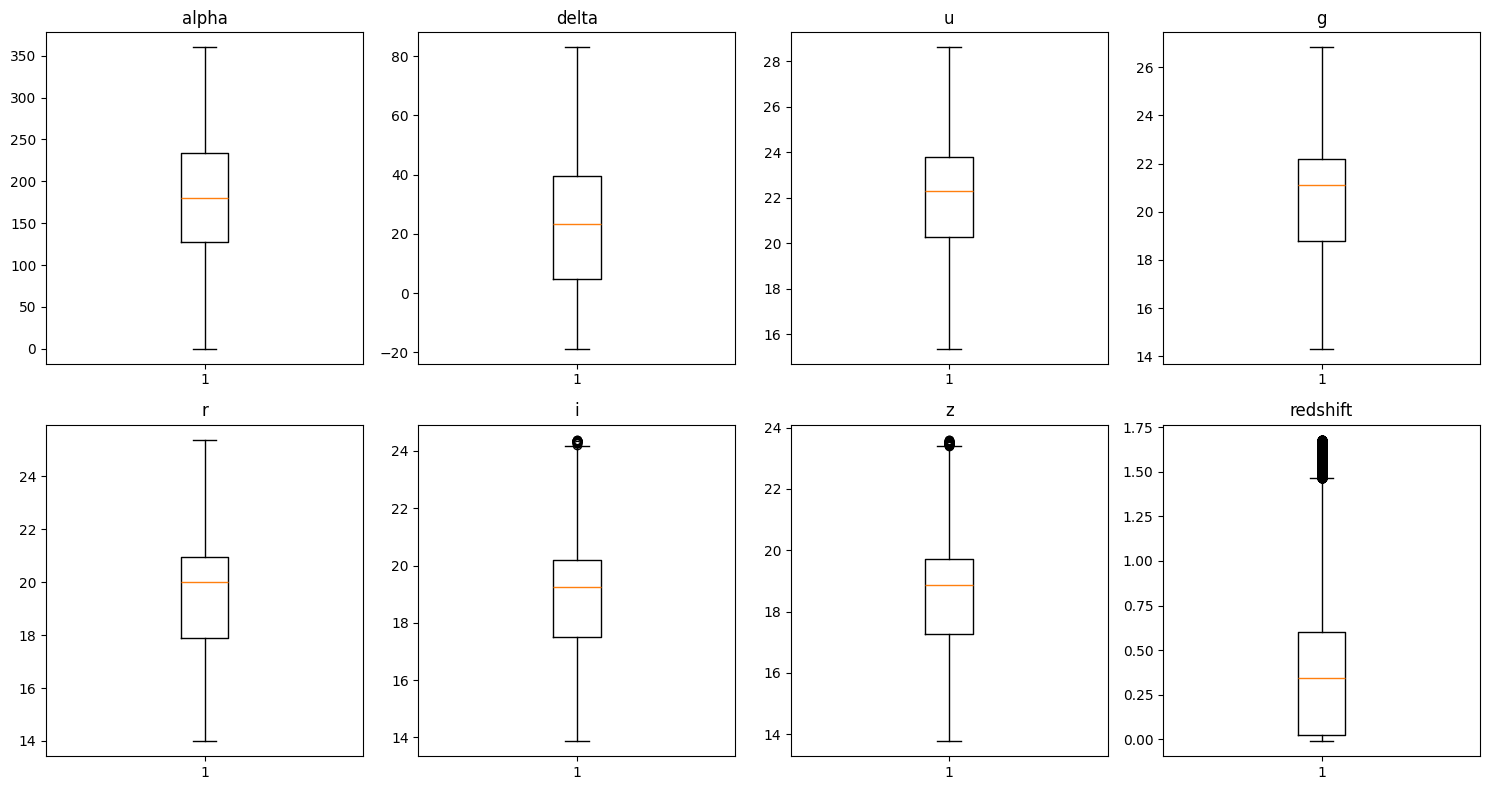

In [ ]:
import matplotlib.pyplot as plot
import seaborn as sns

cols_with_missing_values = raw_df.isna().any(axis=1).sum()
print(f"colunas com valores faltantes: {cols_with_missing_values}")
# no missing values

#excluding ID columns with no fisical meaning
ID_columns = raw_df[["obj_ID","run_ID","rerun_ID","cam_col", "field_ID", "spec_obj_ID", "fiber_ID", "plate"]]
col = ID_columns.columns.tolist();
print(f'samplpes: {len(raw_df)}')
for i in col:
  print(f"{i} : {ID_columns[i].nunique()}")

print("Excluindo as colunas que não se referem a dados físicos e as imagens em si, apenas a data, material utilizado etc.")

df_relevant = raw_df[["alpha",	"delta", "u",	"g", "r", "i", "z","class",	"redshift"]]


def boxplot(df : pd.DataFrame):
  df_num = df_relevant.drop("class", axis=1)
  plot.figure(figsize=(15, 8))
  count = 1
  for i in df_num.columns:
    plot.subplot(2,4,count)
    plot.boxplot(df[i])
    plot.title(i)
    count += 1

  plot.tight_layout()
  plot.show()

boxplot(df_relevant)

#outliers
def rem_outliers(df: pd.DataFrame):
    df_copy = df.copy()
    num_cols = df_copy.select_dtypes(include=['number']).columns
    mask = pd.Series(True, index=df_copy.index)
    for col in num_cols:
        qt1 = df_copy[col].quantile(0.25)
        qt3 = df_copy[col].quantile(0.75)
        iqr =  qt3 - qt1
        lower = qt1-(1.5*iqr)
        upper = qt3+(1.5*iqr)
        mask &= df_copy[col].between(lower, upper)

    df_no_outliers = df_copy[mask]

    outliers = df_copy.shape[0] - df_no_outliers.shape[0]

    print(f"\noutliers removidos: {outliers}\n")
    return df_no_outliers

df = rem_outliers(df_relevant)
boxplot(df)


#label encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df["class"] = label_encoder.fit_transform(df["class"])


# Pytorch

In [ ]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

x = df.drop("class", axis=1).values
y = df["class"].values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(x)

#representa arrays multidimensionais - basicamente ajuda o pytorch a processar
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

            #herda a classe base doo pytorch
class modelNN(nn.Module):
  #construtor da classe mãe

                  #neurônios de entrada  neurônios ocultos   neuônios de saída
  def __init__(self, input_size,         hidden_size,         output_size):
    super(modelNN, self).__init__()

    #gera hidden_size saidas
    self.layer1 = nn.Linear(input_size, hidden_size)
    #função de ativação
    self.relu = nn.ReLU()
    #gera output_size saidas
    self.layer2 = nn.Linear(hidden_size, output_size)
  #como os dados vão se propagar
  def forward(self, x):
    #camada 1
    out = self.layer1(x)
    #elimina valores negativos, mantem os positivos.
    out = self.relu(out)
    #camada 2
    out = self.layer2(out)

    return out


input_size = X_train.shape[1] #qnt de linhas
hidden_size = 16

#mede o erro
model = modelNN(input_size, hidden_size, 3)

              #usado para problemas de classificação
              #vai gerar o loss
criterion = nn.CrossEntropyLoss()

#a partir do loss busca ajustar os pesos
                           #bias/pesos     #learning rate
optimizer = optim.Adam(model.parameters(), lr=0.01)


#treinar
num_epochs = 100
            #quantas vezes vai passar pelos dados
for epoch in range(num_epochs):
  #gerar as saídas
  outputs = model(X_train)
  #calular o erro
  loss = criterion(outputs, y_train)
  #zeras os valores antigos
  optimizer.zero_grad()
  #backpropagation
  loss.backward()
  #atualizar com os novos pesos
  optimizer.step()

  #de 10 em 10 iterações mostrar os progresso

     # no teste n queremos atualizar os pesos e bias
  with torch.no_grad():
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, y_train).item()
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test).item()

    _, predicted = torch.max(test_outputs, 1)
    acc = (predicted == y_test).sum().item() / y_test.size(0)

print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

print(f'\nAccuracy:  {acc:.4f}')

Train Loss: 0.2221, Test Loss: 0.2319

Accuracy:  0.9277


# Largura e Profundidade

In [ ]:
#maior largura, mesma profundidade
class more_width(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(more_width, self).__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    return out

input_size = X_train.shape[1]
hidden_size = 32

#mede o erro
model_more_width = more_width(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_more_width.parameters(), lr=0.01)

#treinar

for epoch in range(num_epochs):
  outputs = model_more_width(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  with torch.no_grad():
    outputs = model_more_width(X_test)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_test).sum().item() / y_test.size(0)

print(f'\nAccuracy with more width:  {acc:.4f}')



#menor largura, mesma profundidade

class less_width(nn.Module):
  #construtor da classe mãe

  def __init__(self, input_size, hidden_size, output_size):
    super(less_width, self).__init__()

    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)

    return out

input_size = X_train.shape[1] #qnt de linhas
hidden_size = 8

#mede o erro
model_less_width = less_width(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_less_width.parameters(), lr=0.01)

#treinar

for epoch in range(num_epochs):
  outputs = model_less_width(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


with torch.no_grad():
  outputs = model_less_width(X_test)
  _, predicted = torch.max(outputs, 1)
  acc = (predicted == y_test).sum().item() / y_test.size(0)

print(f'\nAccuracy with less width:  {acc:.4f}')




#mesma largura, maior profundidade

class more_depth(nn.Module):
  def __init__(self, input_size,         hidden_size,         output_size):
    super(more_depth, self).__init__()

    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)

    return out

input_size = X_train.shape[1] #qnt de linhas
hidden_size = 16

#mede o erro
model_more_depth = more_depth(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_more_depth.parameters(), lr=0.01)

#treinar
for epoch in range(num_epochs):
  outputs = model_more_depth(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


     # no teste n queremos atualizar os pesos e bias
  with torch.no_grad():
    outputs = model_more_depth(X_test)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_test).sum().item() / y_test.size(0)

print(f'\nAccuracy with more depth:  {acc:.4f}')









  #maior largura e profundidade

class more_depth_width(nn.Module):
  def __init__(self, input_size,         hidden_size,         output_size):
    super(more_depth_width, self).__init__()

    self.layer1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, hidden_size)
    self.layer3 = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.relu(out)
    out = self.layer3(out)

    return out

input_size = X_train.shape[1] #qnt de linhas
hidden_size = 64

#mede o erro
model_more_depth_width = more_depth_width(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_more_depth_width.parameters(), lr=0.01)

#treinar
num_epochs = 100
for epoch in range(num_epochs):
  outputs = model_more_depth_width(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


     # no teste n queremos atualizar os pesos e bias
  with torch.no_grad():
    outputs = model_more_depth_width(X_test)
    _, predicted = torch.max(outputs, 1)
    acc = (predicted == y_test).sum().item() / y_test.size(0)

print(f'\nAccuracy with more depth and width:  {acc:.4f}')


Accuracy with more width:  0.9352

Accuracy with less width:  0.8953

Accuracy with more depth:  0.9558

Accuracy with more depth and width:  0.9613


A partir dos resultadps perceb-se que a maior largura influencia um pouco nos resultados, mas a aumentar a profundidade nesse caso foi mais eficiente. Porém ao aumentar as duas o custo ficou caro e programa demorou para finalizar o processo, tendo o resultado apenas 0,04 maior do que o modelo que apenas teve sua profundidade aumentada. Dessa maneira percebe-se que aumentar a profundidade foi a melhor Otimização.

# Épocas e Leraning rate

In [ ]:
# #complex model
print("-"*40 + "\nOverfitting\n" + "-"*40)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.9, random_state=42
)
input_size = X_train.shape[1] #qnt de linhas
hidden_size = 64

#mede o erro
model_more_depth = more_depth(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_more_depth.parameters(), lr=0.01)

#treinar
for epoch in range(2000):
  outputs = model_more_depth(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()


     # no teste n queremos atualizar os pesos e bias
  if (epoch+1) % 400 == 0:
          with torch.no_grad():
              train_outputs = model_more_depth(X_train)
              train_loss = criterion(train_outputs, y_train).item()
              _, train_pred = torch.max(train_outputs, 1)
              train_acc = (train_pred == y_train).sum().item() / y_train.size(0)

              test_outputs = model_more_depth(X_test)
              test_loss = criterion(test_outputs, y_test).item()
              _, test_pred = torch.max(test_outputs, 1)
              test_acc = (test_pred == y_test).sum().item() / y_test.size(0)

          print(f"Epoch {epoch+1}")
          print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
          print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")
          print("-" * 40)


print("\n" + "-"*40 + "\nUderfitting\n" + "-"*40)
# simple model

#voltar o tamanho do treino para o normal
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

input_size = X_train.shape[1] #qnt de linhas
hidden_size = 8


model = modelNN(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#treinar
num_epochs = 50
for epoch in range(num_epochs):
  outputs = model(X_train)
  loss = criterion(outputs, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if (epoch+1) % 10 == 0:
          with torch.no_grad():
              train_outputs = model(X_train)
              train_loss = criterion(train_outputs, y_train).item()
              _, train_pred = torch.max(train_outputs, 1)
              train_acc = (train_pred == y_train).sum().item() / y_train.size(0)

              test_outputs = model(X_test)
              test_loss = criterion(test_outputs, y_test).item()
              _, test_pred = torch.max(test_outputs, 1)
              test_acc = (test_pred == y_test).sum().item() / y_test.size(0)

          print(f"Epoch {epoch+1}")
          print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
          print(f"Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")
          print("-" * 40)

----------------------------------------
Overfitting
----------------------------------------
Epoch 400
Train Loss: 0.0740, Train Acc: 0.9763
Test  Loss: 0.1213, Test  Acc: 0.9654
----------------------------------------
Epoch 800
Train Loss: 0.0694, Train Acc: 0.9778
Test  Loss: 0.1327, Test  Acc: 0.9642
----------------------------------------
Epoch 1200
Train Loss: 0.0453, Train Acc: 0.9849
Test  Loss: 0.1515, Test  Acc: 0.9650
----------------------------------------
Epoch 1600
Train Loss: 0.0618, Train Acc: 0.9801
Test  Loss: 0.1525, Test  Acc: 0.9635
----------------------------------------
Epoch 2000
Train Loss: 0.0357, Train Acc: 0.9883
Test  Loss: 0.1773, Test  Acc: 0.9627
----------------------------------------

----------------------------------------
Uderfitting
----------------------------------------
Epoch 10
Train Loss: 1.0896, Train Acc: 0.2749
Test  Loss: 1.0886, Test  Acc: 0.2793
----------------------------------------
Epoch 20
Train Loss: 1.0546, Train Acc: 0.4209


# Optimazation

In [ ]:
# optimized model
# using the deepest model that had the best accuracy
from torch.utils.data import TensorDataset, DataLoader

class more_depth(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(more_depth, self).__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(hidden_size) #work in batches to make the training better
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=0.3)  # 30% chance of turning a neuron off (to avoid relying only on a few neurons)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.layer1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.dropout(out)
        out = self.layer3(out)

        return out

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

input_size = X_train.shape[1]  # number of features (columns)
hidden_size = 16
model = more_depth(input_size, hidden_size, 3)
criterion = nn.CrossEntropyLoss()

                                 # regularization - penalize high weights
# optimizer = optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.0003)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
                                                     #lowering the lr becouse it was really unstable
best_loss = float('inf')
patience = 5
trigger_times = 0

# training
num_epochs = 50 #will stop if is overfiting
                #does not need that much epochs

for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        # Sempre calcula test loss para early stopping
        total_test_loss = 0
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            total_test_loss += criterion(outputs, batch_y).item()
        total_test_loss /= len(test_loader)

        # Sempre calcula train loss e acc
        train_loss = 0
        train_correct = 0
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            train_loss += criterion(outputs, batch_y).item()
            _, pred = torch.max(outputs, 1)
            train_correct += (pred == batch_y).sum().item()
        train_loss /= len(train_loader)
        train_acc = train_correct / len(train_dataset)

        test_correct = 0
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            _, pred = torch.max(outputs, 1)
            test_correct += (pred == batch_y).sum().item()
        test_acc = test_correct / len(test_dataset)

    # Avoid overfitting
    if total_test_loss < best_loss:
        best_loss = total_test_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    # Print sempre
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {total_test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch 1 - Train Loss: 0.2075, Train Acc: 0.9307, Test Loss: 0.2152, Test Acc: 0.9276
Epoch 2 - Train Loss: 0.1740, Train Acc: 0.9522, Test Loss: 0.1794, Test Acc: 0.9501
Epoch 3 - Train Loss: 0.1782, Train Acc: 0.9350, Test Loss: 0.1870, Test Acc: 0.9298
Epoch 4 - Train Loss: 0.1562, Train Acc: 0.9531, Test Loss: 0.1627, Test Acc: 0.9503
Epoch 5 - Train Loss: 0.1588, Train Acc: 0.9575, Test Loss: 0.1651, Test Acc: 0.9537
Epoch 6 - Train Loss: 0.1585, Train Acc: 0.9494, Test Loss: 0.1655, Test Acc: 0.9460
Epoch 7 - Train Loss: 0.1486, Train Acc: 0.9572, Test Loss: 0.1562, Test Acc: 0.9531
Epoch 8 - Train Loss: 0.1505, Train Acc: 0.9562, Test Loss: 0.1572, Test Acc: 0.9539
Epoch 9 - Train Loss: 0.1454, Train Acc: 0.9598, Test Loss: 0.1515, Test Acc: 0.9573
Epoch 10 - Train Loss: 0.1443, Train Acc: 0.9616, Test Loss: 0.1519, Test Acc: 0.9590
Epoch 11 - Train Loss: 0.1501, Train Acc: 0.9577, Test Loss: 0.1575, Test Acc: 0.9543
Epoch 12 - Train Loss: 0.1454, Train Acc: 0.9617, Test Loss: 0.

Após testar várias métricas e valores (várias mesmo), este modelo se mostrou o mais eficaz e otimizado